In [1]:
import numpy as np
import itertools
import time
import multiprocessing
from multiprocessing import Process, Manager

import matplotlib.pyplot as plt

In [2]:
multiprocessing.cpu_count()

24

In [3]:
k = 30
env = [1,2,3,4,5]
c_f = 100
c_h = [1, 1.5, 2, 2.5, 3]
y = 0.95

A = [0,1]

In [4]:
def get_arrival_configs(c_h, env):
    arr = {x: env for x in c_h}
    keys, values = zip(*arr.items())
    arrival_permutations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    return arrival_permutations

arrival_configs = get_arrival_configs(c_h, env)

In [5]:
def process_arrival(s, cap, arrival_config):
    for c_h in s.keys():
        s[c_h] = min(cap, s[c_h]+arrival_config[c_h])

In [6]:
def load(s, k):
    loaded_s = s.copy()
    classes = sorted(loaded_s.keys(), reverse = True)
    for c_h in classes:
        num_to_load = min(loaded_s[c_h], k)
        loaded_s[c_h] = loaded_s[c_h]-num_to_load
        k = k-num_to_load
        if k == 0:
            break
    return loaded_s

In [7]:
def get_next_state(s, a, k, cap, arrival_config):
    s_prime = s.copy()
    process_arrival(s_prime, cap, arrival_config)
    if a == 1:
        load(s_prime,k)
    return s_prime

In [8]:
def waiting_cost(s):
    cost_by_class = [k*v for (k,v)in s.items()]
    total_cost = sum(cost_by_class)
    return total_cost

In [9]:
def reward(s, a, c_f, k):
    # if a=0 (don't send)
    cost = 0
    if a == 0:
        cost = waiting_cost(s)
    else:
        loaded_s = load(s, k)
        cost = c_f + waiting_cost(loaded_s)
    return -cost

In [10]:
def getEV(s, a, k, cap, arrival_configs, V_t1):
    states = [tuple(get_next_state(s, a, k, cap, e).values()) for e in arrival_configs]
    values = [V_t1[s]*1/len(states) for s in states]
    ev = sum(values)
    return ev

In [11]:
def update(V_t, states):
    results = dict()
    for s in states:
        s_tuple = tuple(s.values())
        results[s_tuple] = max([reward(s, a, c_f, k) + \
            y * getEV(s, a, k, cap, arrival_configs, V_t1) for a in A])
    V_t.update(results)

# Enumeration

In [12]:
cap = 2
S = {x: range(0,cap+1) for x in c_h}

In [13]:
keys, values = zip(*S.items())
states = [dict(zip(keys, v)) for v in itertools.product(*values)]

manager = Manager()
V_t1 = {tuple(s.values()):0 for s in states}
V_t = manager.dict(V_t1.copy())

In [14]:
n_chunks = 16
start_time = time.time()
for t in range(500,-1,-1):
    epoch_start = time.time()
    state_chunks = np.array_split(states, n_chunks)
    job = [Process(target=update, args=(V_t, state_chunks[i])) for i in range(0,n_chunks)]
    _ = [p.start() for p in job]
    _ = [p.join() for p in job]
    V_t1 = V_t.copy()
    if t % 25 == 0:
        print("Epoch {0} completed in {1:0.2f} seconds".format(t, time.time()-epoch_start))
print("Finished in {0:0.2f} seconds".format(time.time()-start_time))

Epoch 500 completed in 0.58 seconds
Epoch 475 completed in 0.65 seconds
Epoch 450 completed in 0.57 seconds
Epoch 425 completed in 0.58 seconds
Epoch 400 completed in 0.57 seconds
Epoch 375 completed in 0.57 seconds
Epoch 350 completed in 0.58 seconds
Epoch 325 completed in 0.57 seconds
Epoch 300 completed in 0.57 seconds
Epoch 275 completed in 0.69 seconds
Epoch 250 completed in 0.57 seconds
Epoch 225 completed in 0.58 seconds
Epoch 200 completed in 0.57 seconds
Epoch 175 completed in 0.57 seconds
Epoch 150 completed in 0.86 seconds
Epoch 125 completed in 0.58 seconds
Epoch 100 completed in 0.57 seconds
Epoch 75 completed in 0.57 seconds
Epoch 50 completed in 0.58 seconds
Epoch 25 completed in 0.57 seconds
Epoch 0 completed in 0.58 seconds
Finished in 292.10 seconds


Text(0,0.5,'Value')

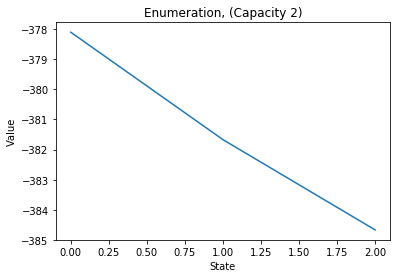

In [15]:
result = []
for i in range(cap+1):
    result.append(V_t[(0,0,0,0,i)])

plt.plot(range(cap+1), result)
plt.title("Enumeration, (Capacity 2)")
plt.xlabel("State")
plt.ylabel("Value")

# Value Iteration

## Station Capacity: 2

In [16]:
cap = 2
S = {x: range(0,cap+1) for x in c_h}

In [17]:
keys, values = zip(*S.items())
states = [dict(zip(keys, v)) for v in itertools.product(*values)]

manager = Manager()
V_t1 = {tuple(s.values()):0 for s in states}
V_t = manager.dict(V_t1.copy())

In [18]:
start_time = time.time()
theta = 1e-3
delta = 1e6 
n_chunks = 16
epoch = 0 
while delta > theta:
    epoch += 1
    epoch_start = time.time()
    V_t1 = V_t.copy()
    state_chunks = np.array_split(states, n_chunks)
    job = [Process(target=update, args=(V_t, state_chunks[i])) for i in range(0,n_chunks)]
    _ = [p.start() for p in job]
    _ = [p.join() for p in job]
    delta = min(delta, max([V_t1[s]-V_t[s] for s in V_t.keys()]))
    if epoch % 10 == 0:
        print("Epoch: {0}, Delta: {1:.2E}, Epoch Time (s): {2:.2f}".format(epoch, delta, time.time()-epoch_start))
    
print("Finished in {0} epochs and {1:.2f} seconds".format(epoch, time.time()-start_time))

Epoch: 10, Delta: 1.26E+01, Epoch Time (s): 0.61
Epoch: 20, Delta: 7.55E+00, Epoch Time (s): 0.54
Epoch: 30, Delta: 4.52E+00, Epoch Time (s): 0.55
Epoch: 40, Delta: 2.71E+00, Epoch Time (s): 0.54
Epoch: 50, Delta: 1.62E+00, Epoch Time (s): 0.54
Epoch: 60, Delta: 9.70E-01, Epoch Time (s): 0.55
Epoch: 70, Delta: 5.81E-01, Epoch Time (s): 0.54
Epoch: 80, Delta: 3.48E-01, Epoch Time (s): 0.54
Epoch: 90, Delta: 2.08E-01, Epoch Time (s): 0.54
Epoch: 100, Delta: 1.25E-01, Epoch Time (s): 0.54
Epoch: 110, Delta: 7.46E-02, Epoch Time (s): 0.55
Epoch: 120, Delta: 4.47E-02, Epoch Time (s): 0.55
Epoch: 130, Delta: 2.68E-02, Epoch Time (s): 0.55
Epoch: 140, Delta: 1.60E-02, Epoch Time (s): 0.55
Epoch: 150, Delta: 9.59E-03, Epoch Time (s): 0.95
Epoch: 160, Delta: 5.74E-03, Epoch Time (s): 0.54
Epoch: 170, Delta: 3.44E-03, Epoch Time (s): 0.62
Epoch: 180, Delta: 2.06E-03, Epoch Time (s): 0.54
Epoch: 190, Delta: 1.23E-03, Epoch Time (s): 0.55
Finished in 195 epochs and 111.48 seconds


In [19]:
result = []
for i in range(cap+1):
    result.append(V_t[(0,0,0,0,i)])

Text(0,0.5,'Value')

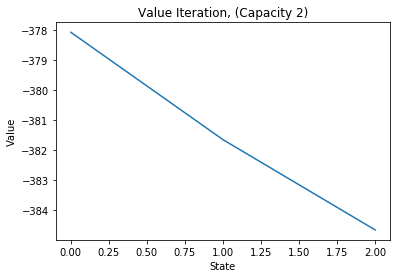

In [20]:
plt.plot(range(cap+1), result)
plt.title("Value Iteration, (Capacity 2)")
plt.xlabel("State")
plt.ylabel("Value")

## Station Capacity: 3

In [28]:
cap = 3
S = {x: range(0,cap+1) for x in c_h}

In [29]:
keys, values = zip(*S.items())
states = [dict(zip(keys, v)) for v in itertools.product(*values)]

manager = Manager()
V_t1 = {tuple(s.values()):0 for s in states}
V_t = manager.dict(V_t1.copy())

In [30]:
start_time = time.time()
theta = 1e-3
delta = 1e6 
n_chunks = 16
epoch = 0 
while delta > theta:
    epoch += 1
    epoch_start = time.time()
    V_t1 = V_t.copy()
    state_chunks = np.array_split(states, n_chunks)
    job = [Process(target=update, args=(V_t, state_chunks[i])) for i in range(0,n_chunks)]
    _ = [p.start() for p in job]
    _ = [p.join() for p in job]
    delta = min(delta, max([V_t1[s]-V_t[s] for s in V_t.keys()]))
    if epoch % 10 == 0:
        print("Epoch: {0}, Delta: {1:.2E}, Epoch Time (s): {2:.2f}".format(epoch, delta, time.time()-epoch_start))
    
print("Finished in {0} epochs and {1:.2f} seconds".format(epoch, time.time()-start_time))

Epoch: 10, Delta: 1.89E+01, Epoch Time (s): 2.13
Epoch: 20, Delta: 1.13E+01, Epoch Time (s): 2.12
Epoch: 30, Delta: 6.78E+00, Epoch Time (s): 2.12
Epoch: 40, Delta: 4.06E+00, Epoch Time (s): 2.12
Epoch: 50, Delta: 2.43E+00, Epoch Time (s): 2.20
Epoch: 60, Delta: 1.45E+00, Epoch Time (s): 2.13
Epoch: 70, Delta: 8.71E-01, Epoch Time (s): 2.91
Epoch: 80, Delta: 5.22E-01, Epoch Time (s): 2.47
Epoch: 90, Delta: 3.12E-01, Epoch Time (s): 2.15
Epoch: 100, Delta: 1.87E-01, Epoch Time (s): 2.44
Epoch: 110, Delta: 1.12E-01, Epoch Time (s): 2.15
Epoch: 120, Delta: 6.70E-02, Epoch Time (s): 2.14
Epoch: 130, Delta: 4.01E-02, Epoch Time (s): 2.16
Epoch: 140, Delta: 2.40E-02, Epoch Time (s): 2.14
Epoch: 150, Delta: 1.44E-02, Epoch Time (s): 2.13
Epoch: 160, Delta: 8.61E-03, Epoch Time (s): 2.12
Epoch: 170, Delta: 5.16E-03, Epoch Time (s): 2.14
Epoch: 180, Delta: 3.09E-03, Epoch Time (s): 2.14
Epoch: 190, Delta: 1.85E-03, Epoch Time (s): 2.17
Epoch: 200, Delta: 1.11E-03, Epoch Time (s): 2.13
Finished 

In [31]:
result = []
for i in range(cap+1):
    result.append(V_t[(0,0,0,0,i)])

Text(0,0.5,'Value')

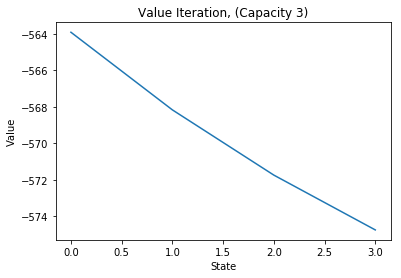

In [32]:
plt.plot(range(cap+1), result)
plt.title("Value Iteration, (Capacity 3)")
plt.xlabel("State")
plt.ylabel("Value")

# Policy Iteration

In [33]:
def policy_update(V_t, states, policy):
    values = dict()
    results = dict()
    results_bestval = dict()
    for s in states:
        s_tuple = tuple(s.values())
        values[s_tuple] = [reward(s, a, c_f, k) + \
            y * getEV(s, a, k, cap, arrival_configs, V_t1) for a in A]
        results[s_tuple] = values[s_tuple][policy[s_tuple]]
        results_bestval[s_tuple] = np.argmax(values)
    V_t.update(results)
    best_values.update(results_bestval)

In [34]:
best_values = {s: None for s in S}

In [35]:
cap = 2
S = {x: range(0,cap+1) for x in c_h}

In [36]:
keys, values = zip(*S.items())
states = [dict(zip(keys, v)) for v in itertools.product(*values)]

manager = Manager()
V_t1 = {tuple(s.values()):0 for s in states}
V_t = manager.dict(V_t1.copy())

best_values = manager.dict({tuple(s.values()):None for s in states})

policy = {tuple(s.values()): np.random.randint(2) for s in states}
policy_1 = {tuple(s.values()): np.random.randint(2) for s in states}


In [37]:
start_time = time.time()
theta = 1e-3
n_chunks = 16
epoch = 0
policy_num = 0
while True:
    
    policy_start = time.time()
    policy_num += 1
    delta = 1e6 
    
    print("Policy Iteration: {}".format(policy_num))
    
    V_t1 = {tuple(s.values()):0 for s in states}
    V_t = manager.dict(V_t1.copy())

    while delta > theta:
        epoch += 1
        epoch_start = time.time()
        V_t1 = V_t.copy()
        state_chunks = np.array_split(states, n_chunks)
        job = [Process(target=policy_update, args=(V_t, state_chunks[i], policy)) for i in range(0,n_chunks)]
        _ = [p.start() for p in job]
        _ = [p.join() for p in job]
        delta = min(delta, max([V_t1[s]-V_t[s] for s in V_t.keys()]))
        if epoch % 20 == 0:
            print("\t Epoch: {0}, Delta: {1:.2E}, Epoch Time (s): {2:.2f}".format(epoch, delta, time.time()-epoch_start))
    
    policy_1 = best_values.copy()
    
    print("Policy Iteration {0} completed in {1:.2f} seconds".format(policy_num, time.time()- policy_start))
    
    # policy improvement
    if all([policy_1[tuple(s.values())] == policy[tuple(s.values())] for s in states]):
        break
    else:
        policy = policy_1.copy()

print("Finished in {0} policy iterations and {1:.2f} seconds".format(policy_num, time.time()-start_time))

Policy Iteration: 1
	 Epoch: 20, Delta: 7.55E+00, Epoch Time (s): 0.55
	 Epoch: 40, Delta: 2.71E+00, Epoch Time (s): 0.55
	 Epoch: 60, Delta: 9.70E-01, Epoch Time (s): 0.55
	 Epoch: 80, Delta: 3.48E-01, Epoch Time (s): 0.55
	 Epoch: 100, Delta: 1.25E-01, Epoch Time (s): 0.55
	 Epoch: 120, Delta: 4.47E-02, Epoch Time (s): 0.55
	 Epoch: 140, Delta: 1.60E-02, Epoch Time (s): 0.54
	 Epoch: 160, Delta: 5.74E-03, Epoch Time (s): 0.54
	 Epoch: 180, Delta: 2.06E-03, Epoch Time (s): 0.55
Policy Iteration 1 completed in 108.75 seconds
Policy Iteration: 2
	 Epoch: 200, Delta: 1.63E+01, Epoch Time (s): 0.55
	 Epoch: 220, Delta: 5.84E+00, Epoch Time (s): 0.55
	 Epoch: 240, Delta: 2.09E+00, Epoch Time (s): 0.56
	 Epoch: 260, Delta: 7.50E-01, Epoch Time (s): 0.54
	 Epoch: 280, Delta: 2.69E-01, Epoch Time (s): 0.54
	 Epoch: 300, Delta: 9.64E-02, Epoch Time (s): 0.69
	 Epoch: 320, Delta: 3.46E-02, Epoch Time (s): 0.55
	 Epoch: 340, Delta: 1.24E-02, Epoch Time (s): 0.55
	 Epoch: 360, Delta: 4.44E-03, Ep

In [38]:
result = []
for i in range(cap+1):
    result.append(policy[(0,0,0,0,i)])

Text(0,0.5,'Policy (1: send, 0: no send)')

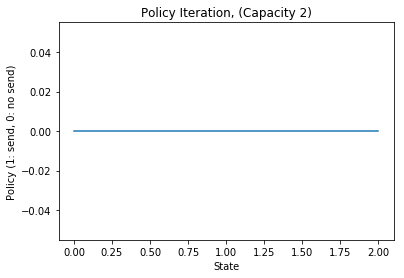

In [39]:
plt.plot(range(cap+1), result)
plt.title("Policy Iteration, (Capacity 2)")
plt.xlabel("State")
plt.ylabel("Policy (1: send, 0: no send)")